In [33]:
import pathlib, sys, datetime
from functools import reduce
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


main_path = pathlib.Path(r'C:\Main\Data\_\Result\Mix')
# main_folders = [
#     '20230101_17_VarAnalysis_60m_5m',
#     '20230101_18_VarAnalysis_60m_10m',
#     '20230101_19_VarAnalysis_60m_15m',
#     '20230101_21_VarAnalysis_60m_30m',
#     '20230101_22_VarAnalysis_60m_60m'
# ]
main_folders = [
    '20220904_16_VarAnalysis_60m_2s',
    '20230118_00_VarAnalysis_60m_5s',
    '20230118_01_VarAnalysis_60m_10s',
    '20230118_02_VarAnalysis_60m_15s',
    '20230118_03_VarAnalysis_60m_30s',
    '20230118_04_VarAnalysis_60m_45s',
    '20230114_18_VarAnalysis_60m_60s'
]
sub_folder = 'Chart\Extube_SumP12_Nad'
pathes = [main_path/f/sub_folder for f in main_folders]

In [34]:
def get_bv(df:pd.DataFrame):
    inds = df.columns.tolist()
    mets = df.index.tolist()
    cols, vals = [], []
    for m in mets:
        for i in inds:
            cols.append('-'.join([m, i]))
            vals.append(df.loc[m, i])
    row = pd.Series(dict(zip(cols, vals)))
    return row

def SaveGen(p_loc: pathlib.Path, fold_n: str) -> pathlib.Path:
    now = datetime.datetime.now()
    p_loc = pathlib.Path(p_loc) if not isinstance(p_loc, pathlib.PurePath) else p_loc
    fold_pre = '{0}{1}{2}_{3}_'.format(now.year,
                                       str(now.month).rjust(2, '0'),
                                       str(now.day).rjust(2, '0'),
                                       str(now.hour).rjust(2, '0'))
    save_loc = p_loc / (fold_pre + fold_n)
    save_loc.mkdir(parents=True, exist_ok=True)
    return save_loc

def main(s_p:pathlib.Path, type_i:int=2):
    df_s = []
    for path in pathes:
        row_p = get_bv(pd.read_csv(path/'P_HeatMap.csv', index_col='method'))
        row_auc = get_bv(pd.read_csv(path/'AUC_HeatMap.csv', index_col='method'))
        type_n = path.parts[6].split('_')[-1]

        with open(s_p / 'info.txt', 'a') as f:
            info_l = [type_n, row_p[row_p<0.01].shape[0], row_p[row_p<0.05].shape[0]]
            f.write('Scale: {0}\tP < 0.01: {1}\tP < 0.05: {2}\n'.format(*info_l))
            
        col_n = [type_n+'_'+i for i in ['feat','p','auc'] ]
        val_s = [row_p.index.to_list(), row_p.values.tolist(), row_auc.values.tolist()]
        df_p = pd.DataFrame(dict(zip(col_n,val_s)))
        df_p = df_p.sort_values(by=col_n[1])
        df_p = df_p.reset_index(drop=True)
        df_p.to_csv(s_p/(type_n+'_scale.csv'),index=False)
        df_s.append(df_p)

    df = pd.concat(df_s, axis=1)
    df.to_csv(s_p/'main.csv', index=False)

    return df

In [35]:
p_name = 'BreathVarScaleExp'
save_path = SaveGen(pathlib.Path(r'C:\Main\Data\_\Result\Graph'), p_name)
df = main(save_path)

In [36]:
param_slt = ['mp_jl_d', 'mp_jm_d', 'mp_jb_d', 'pip', 'rr', 'v_t', 've', 'rsbi']
feat_series = [df[i][0:30] for i in df.columns if 'feat' in i]
feat_slt = reduce(np.intersect1d, (feat_series))
feat_slt = [i for i in feat_slt if i.split('-')[1] in param_slt]
feat_slt

['cv-mp_jb_d', 'cv-v_t', 'sd1-pip', 'sd2-v_t', 'std-v_t']

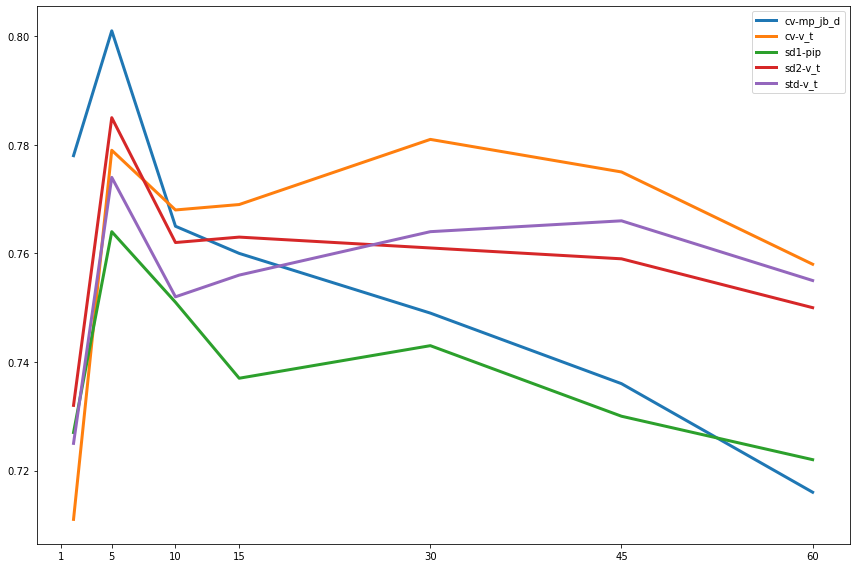

In [43]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
cols = [i for i in df.columns if 'auc' in i]
x_axis = [2, 5, 10, 15, 30, 45, 60]
for feat in feat_slt:
    values = []
    for x in x_axis:
        df_p = df[[i for i in df.columns if str(x) in i]]
        df_p = df_p.set_index(df_p.columns[0], drop=True)
        v = df_p.loc[feat, str(x)+'s_auc']
        values.append(v)
    ax.plot(x_axis, values, label=feat, linewidth=3)
ax.set_xticks([1, 5, 10, 15, 30, 45, 60])
fig.tight_layout()
plt.legend()
fig.savefig(save_path/'chart.png',dpi=300)
plt.show()

In [24]:
df.loc['cv-v_t', '45s_auc']

0.746